<a href="https://colab.research.google.com/github/GKD-stack/DSC180A-Methodology-1/blob/main/DSC180A_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install pandas_plink
from pandas_plink import read_plink
import pandas_plink as pdplink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up Summary Stat File Pipeline Function

In [ ]:
def get_genefiles(chromosome, start_coord, end_coord,gene_abv):
  """
  This function gives the command to get the genotype for a particular gene locus
  """
  c = f"""plink --bfile LDREF/1000G.EUR.{chromosome} --chr {chromosome} --from-bp {start_coord-500000} --to-bp {end_coord+500000} --make-bed --out 1000G.EUR.{chromosome}.{gene_abv}"""
  return c

In [ ]:
# Load expression data
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

expr_data = pd.read_table("/content/drive/My Drive/Colab Notebooks/exp.txt", sep="\t")

def make_summary_stats(long_gene_symbol, chromosome,gene_abv):
  """
  This function takes some chromosome and gene info and generates a summary stats txt file
  """
  expr_data['TargetID_without_version'] = expr_data['TargetID'].str.split('.').str[0]
  expr_data['Gene_Symbol_without_version'] = expr_data['Gene_Symbol'].str.split('.').str[0]
  bcr_expr = expr_data[expr_data["Gene_Symbol_without_version"] == long_gene_symbol]
  bcr_vals = bcr_expr.drop(columns=['TargetID','Gene_Symbol', 'Chr', 'Coord', 'TargetID_without_version', 'Gene_Symbol_without_version'])

  #Load genotype data
  (bim, fam, bed) = read_plink(f'/content/drive/My Drive/Colab Notebooks/1000G.EUR.{chromosome}.{gene_abv}')

  #filter fam
  fam_ids = fam['fid'].tolist()
  expression_ids = bcr_vals.columns.tolist()
  common_ids = set(fam_ids) & set(expression_ids)
  fam_df_filtered = fam[fam['fid'].isin(common_ids)]
  expression_df_filtered = bcr_vals[common_ids]

  #make sure IDs line up
  fam_df_sorted = fam_df_filtered.sort_values(by='fid')
  expression_df_sorted = expression_df_filtered[sorted(expression_df_filtered.columns.tolist())]

  #filter bed
  expression_ids = expression_df_sorted.columns.tolist()
  fam_ids = fam_df_sorted.iloc[:, 1].tolist()
  indices = [fam_ids.index(exp_id) for exp_id in expression_ids if exp_id in fam_ids]
  bed_filtered = bed[:, indices]
  expression_values = expression_df_filtered.iloc[0, :].values

  #get p values
  p_values = []
  best_p = 99999
  best_snp = None
  for snp_index in range(bed_filtered.shape[0]):
      genotype = bed_filtered[snp_index, :]
      X = sm.add_constant(genotype)
      model = sm.OLS(expression_values, X)
      results = model.fit()
      p_values.append(results.pvalues[1])

      if results.pvalues[1] < best_p:
        best_p = results.pvalues[1]
        best_snp = snp_index

  p_values = np.array(p_values)
  summary_stats = pd.DataFrame({
      'CHR': chromosome,
      'POS': bim['pos'].values,  # Genomic positions of SNPs
      'REF': bim['a0'].values,  # Reference alleles
      'ALT': bim['a1'].values,  # Alternative alleles
      'P': p_values  # Calculated p-values
  })

  # Optionally, convert P-values to -log10(p) if required
  summary_stats['NEG_LOG10_P'] = -np.log10(summary_stats['P'])
  sorted_summary_stats = summary_stats.sort_values(by=['POS'])
  # Save the sorted data to a text file
  sorted_summary_stats.to_csv(f'/content/drive/My Drive/Colab Notebooks/{gene_abv}_Summary_Stats.txt',
                              sep='\t',
                              index=False)

  #get viz
  snp_positions = bim['pos'].values
  negative_log10_p_values = -np.log10(p_values)
  plt.figure(figsize=(10, 5))
  plt.scatter(snp_positions, negative_log10_p_values, color='blue', s=5)
  plt.xlabel('Genomic Coordinate (Position)')
  plt.ylabel('-log10(p-value)')
  plt.title(f'LocusZoom-like Plot for Gene {gene_abv} eQTL Analysis')
  plt.grid(True, which="both", ls="--", c='0.7')
  plt.tight_layout()
  plt.show()

  return best_snp

# Generate genotype files, make summary stats, and make LocusZoom plots here and on the actual website

Here are the links for the 3 plots I made:



1.   BCR: https://my.locuszoom.org/gwas/559583/
2.   COMT: https://my.locuszoom.org/gwas/899895/
3.   ZDHHC8: https://my.locuszoom.org/gwas/669679/



In [ ]:
get_genefiles(22, 23179703, 23318037,'BCR')

'plink --bfile LDREF/1000G.EUR.22 --chr 22 --from-bp 22679703 --to-bp 23818037 --make-bed --out 1000G.EUR.22.BCR'

In [ ]:
get_genefiles(22, 20129455, 20148007,'ZDHHC8')

'plink --bfile LDREF/1000G.EUR.22 --chr 22 --from-bp 19629455 --to-bp 20648007 --make-bed --out 1000G.EUR.22.ZDHHC8'

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
<ipython-input-45-0730785b6e4e>:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  expression_df_filtered = bcr_vals[common_ids]


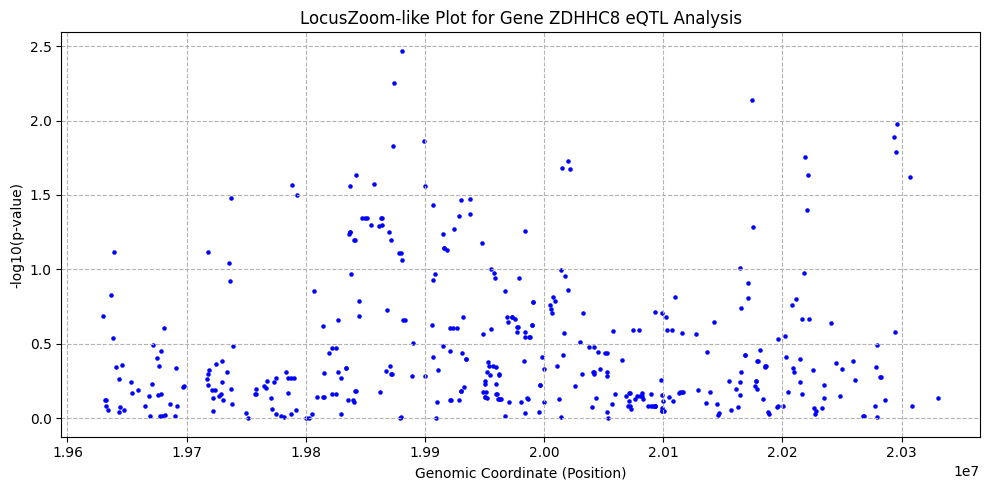

In [ ]:
make_summary_stats("ENSG00000099904", 22,"ZDHHC8")

In [ ]:
get_genefiles(22, 19950941, 19967694,'COMT')

'plink --bfile LDREF/1000G.EUR.22 --chr 22 --from-bp 19450941 --to-bp 20467694 --make-bed --out 1000G.EUR.22.COMT'

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 130.77it/s]
<ipython-input-19-71ba8c0a8a2f>:26: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  expression_df_filtered = bcr_vals[common_ids]


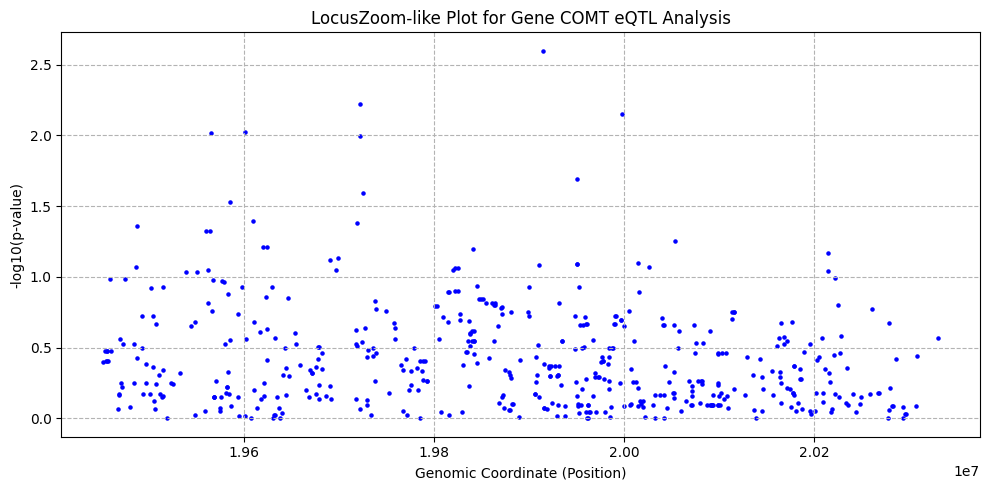

258

In [ ]:
make_summary_stats("ENSG00000093010", 22,"COMT")

# Weekly Questions

## How many significant cis-eQTLs did you find on chr 22? (e.g. p-value < 0.05/number of SNP-gene pairs you tested)

In [ ]:
zdf = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ZDHHC8_Summary_Stats.txt", delimiter="\t")
cdf = pd.read_csv("/content/drive/My Drive/Colab Notebooks/COMT_Summary_Stats.txt", delimiter="\t")
bdf = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Sorted_BCR_Summary_Stats.txt", delimiter="\t")
bdf

,CHR,POS,REF,ALT,P,NEG_LOG10_P
0,22,22681765,A,G,0.838161,0.076672
1,22,22685340,T,C,0.451691,0.345158
2,22,22694313,A,G,0.991358,0.003770
3,22,22694382,A,G,0.991358,0.003770
4,22,22694486,G,A,0.388826,0.410244
...,...,...,...,...,...,...
302,22,23650987,T,G,0.686506,0.163356
303,22,23654436,G,A,0.443039,0.353558
304,22,23666379,T,G,0.934429,0.029454
305,22,23667731,C,T,0.756186,0.121371


In [ ]:
threshold = 0.05 / (zdf.shape[0] + cdf.shape[0] + bdf.shape[0])
p_values = []
for df in [zdf, bdf, cdf]:
  p_values.extend(list(df['NEG_LOG10_P']))
sig_cis = np.sum([1 if p < threshold else 0 for p in p_values])
sig_cis

0

In [ ]:
sig_cis_relaxed = np.sum([1 if p < .05 else 0 for p in p_values])
sig_cis_relaxed

171

In [ ]:
sig_cis_relaxed = np.sum([1 if p < .01 else 0 for p in p_values])
sig_cis_relaxed

44

## For any one gene locus (I chose COMT), how many cis-eQTLs have LD r2 > X with the lead variant? Where X is 0.8, 0.5, 0.1



In [ ]:
cdf.sort_values(by=['P'])

,CHR,POS,REF,ALT,P,NEG_LOG10_P
7,22,19458412,G,A,0.008391,2.076194
33,22,19505531,T,C,0.013743,1.861912
9,22,19467462,T,G,0.013743,1.861912
342,22,20004704,C,T,0.013813,1.859706
89,22,19613784,G,A,0.022777,1.642510
...,...,...,...,...,...,...
385,22,20071737,C,T,0.995907,0.001781
184,22,19802779,T,C,0.996754,0.001412
183,22,19800322,C,T,0.996754,0.001412
68,22,19579962,C,A,0.998206,0.000780


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 128.18it/s]
<ipython-input-19-71ba8c0a8a2f>:26: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  expression_df_filtered = bcr_vals[common_ids]


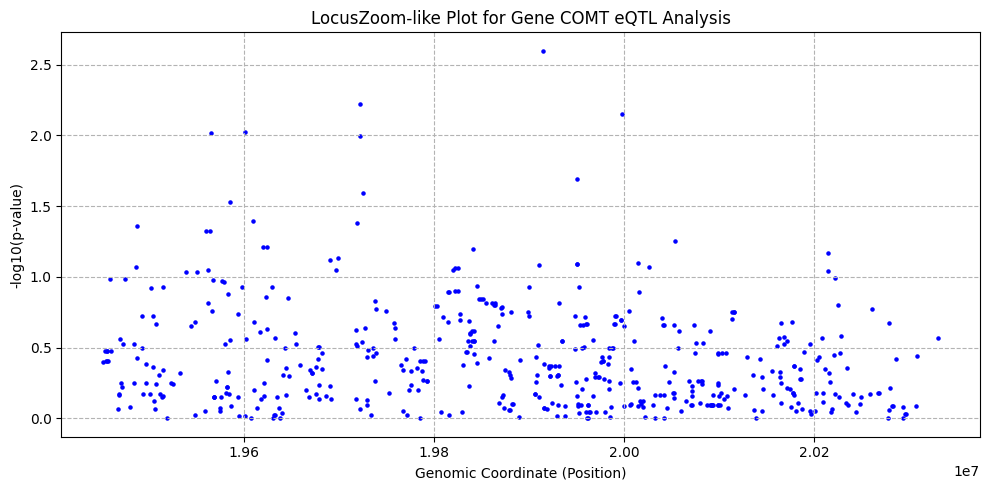

258

In [ ]:
lead_variant_snp_index = make_summary_stats("ENSG00000093010", 22,"COMT")
lead_variant_snp_index

In [ ]:
(bim, fam, bed) = read_plink(f'/content/drive/My Drive/Colab Notebooks/1000G.EUR.22.COMT')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 151.81it/s]


In [ ]:
bim

,chrom,snp,cm,pos,a0,a1,i
0,22,rs5748218,9.859647,19451186,C,A,0
1,22,rs2072055,9.859655,19453275,G,A,1
2,22,rs4493360,9.859661,19454787,T,C,2
3,22,rs5746742,9.859664,19455376,C,T,3
4,22,rs756658,9.859665,19455836,A,G,4
...,...,...,...,...,...,...,...
504,22,rs4425183,12.138583,20295420,T,G,504
505,22,rs4995261,12.139334,20296540,C,T,505
506,22,rs2280117,12.141246,20306993,T,C,506
507,22,rs1210829,12.152501,20308800,A,C,507


In [ ]:
lead_snp = bim.iloc[lead_variant_snp_index]['snp']
lead_snp

'rs17210001'

In [ ]:
bim.iloc[34]['snp']

'rs2073760'


Threw an error
```
plink --bfile 1000G.EUR.22.COMT --ld rs17210001 --ld-window-kb 500000 --ld-window-r2 0 --out ld_comt

```
I did this to get all the LDs between all pairs of SNPs in this window and ill filter them to get the snps that are my lead snp and then do the threshold

```
plink --bfile 1000G.EUR.22.COMT --r2 --ld-window-kb 500 --ld-window-r2 0 --out ld_comt

```




In [ ]:
ldf = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ld_comt.ld", delim_whitespace=True)
ldf

In [ ]:
for lead_variant in [7,33,9,342,89]:
  lead_var_snp = bim.iloc[lead_variant]['snp']
  filtered_ld = ldf[(ldf['SNP_A'] == lead_var_snp) | (ldf['SNP_B'] == lead_var_snp)]
  thresholds = [0.8, 0.5, 0.1]
  print(lead_var_snp)
  for thresh in thresholds:
    count = filtered_ld[filtered_ld['R2'] > thresh].shape[0]
    print(f"Number of SNPs with LD R2 > {thresh}: {count}")


rs17811336
Number of SNPs with LD R2 > 0.8: 0
Number of SNPs with LD R2 > 0.5: 1
Number of SNPs with LD R2 > 0.1: 10
rs13447284
Number of SNPs with LD R2 > 0.8: 0
Number of SNPs with LD R2 > 0.5: 0
Number of SNPs with LD R2 > 0.1: 2
rs13447182
Number of SNPs with LD R2 > 0.8: 0
Number of SNPs with LD R2 > 0.5: 0
Number of SNPs with LD R2 > 0.1: 4
rs2531716
Number of SNPs with LD R2 > 0.8: 0
Number of SNPs with LD R2 > 0.5: 1
Number of SNPs with LD R2 > 0.1: 10
rs5993743
Number of SNPs with LD R2 > 0.8: 0
Number of SNPs with LD R2 > 0.5: 1
Number of SNPs with LD R2 > 0.1: 2


NOTE: the bigger r squared = mor complex disease